<a href="https://colab.research.google.com/github/AI4Finance-LLC/FinRL-Library/blob/master/FinRL_multiple_stock_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

Tutorials to use OpenAI DRL to trade multiple stocks in one Jupyter Notebook | Presented at NeurIPS 2020: Deep RL Workshop

* This blog is based on our paper: FinRL: A Deep Reinforcement Learning Library for Automated Stock Trading in Quantitative Finance, presented at NeurIPS 2020: Deep RL Workshop.
* Check out medium blog for detailed explanations: https://towardsdatascience.com/finrl-for-quantitative-finance-tutorial-for-multiple-stock-trading-7b00763b7530
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
# ## install finrl library
# !pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_stocktrading import StockTradingEnv
from finrl.model.models import DRLAgent
from finrl.trade.backtest import BackTestStats, BaselineStats, BackTestPlot

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

<a id='1.4'></a>
## 2.4. Create Folders

In [4]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [5]:
# from config.py start_date is a string
config.START_DATE

'2000-01-01'

In [6]:
print(config.SRI_KEHATI_TICKER)

['AALI.JK', 'ADHI.JK', 'ASII.JK', 'BBCA.JK', 'BBNI.JK', 'BBRI.JK', 'BBTN.JK', 'BMRI.JK', 'BSDE.JK', 'INDF.JK', 'JPFA.JK', 'JSMR.JK', 'KLBF.JK', 'PGAS.JK', 'PJAA.JK', 'PPRO.JK', 'SIDO.JK', 'SMGR.JK', 'TINS.JK', 'TLKM.JK', 'UNTR.JK', 'UNVR.JK', 'WIKA.JK', 'WSKT.JK', 'WTON.JK']


In [7]:
df = YahooDownloader(start_date = config.START_DATE,
                     end_date = "2021-01-21",
                     ticker_list = config.SRI_KEHATI_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [10]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2000-09-05,455.351990,455.351990,441.553986,266.565033,3712344,UNTR.JK,1
1,2000-09-06,441.553986,464.552002,436.954010,269.284821,6793100,UNTR.JK,2
2,2000-09-07,450.752991,459.951996,446.153015,269.284821,5011393,UNTR.JK,3
3,2000-09-08,450.752991,455.351990,446.153015,266.565033,2277955,UNTR.JK,4
4,2000-09-11,441.553986,441.553986,427.755005,255.684875,978363,UNTR.JK,0


In [11]:
df.shape

(92694, 8)

In [12]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,2000-09-05,455.351990,455.351990,441.553986,266.565033,3712344,UNTR.JK,1
1,2000-09-06,441.553986,464.552002,436.954010,269.284821,6793100,UNTR.JK,2
2,2000-09-07,450.752991,459.951996,446.153015,269.284821,5011393,UNTR.JK,3
3,2000-09-08,450.752991,455.351990,446.153015,266.565033,2277955,UNTR.JK,4
4,2000-09-11,441.553986,441.553986,427.755005,255.684875,978363,UNTR.JK,0


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.
* Impute Missing Value with 0

In [13]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added turbulence index


In [14]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [15]:
processed_full.sample(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
7696,2001-07-09,WSKT.JK,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
51107,2006-04-11,UNVR.JK,850.0,855.0,845.0,158.898605,20.0,1.0,86.467691,5022.089200,4703.199960,59.745502,84.531441,9.823663,4775.895866,4606.851107,22.007045
19484,2002-10-24,KLBF.JK,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
58315,2007-01-24,SMGR.JK,3900.0,3900.0,3860.0,2206.146973,370000.0,2.0,0.029718,23.821223,19.761006,53.880038,98.476133,23.691440,22.424441,21.908397,9.175157
85210,2010-01-04,PGAS.JK,3950.0,3950.0,3900.0,2485.155518,4.0,0.0,-74.823667,12766.687102,11980.766413,41.942242,-36.337193,1.597164,12332.657031,12818.062402,10.730794
144882,2016-07-18,UNVR.JK,8895.0,8895.0,8740.0,7657.485840,13814000.0,0.0,3.360856,662.509838,603.230353,51.899057,52.413217,23.102450,628.974304,624.201967,59.329539
40432,2005-02-08,UNVR.JK,710.0,710.0,705.0,102.658615,3995000.0,1.0,95.359573,6307.406704,5501.288999,54.798152,25.347966,5.137753,5816.704362,5643.768001,1.525286
61973,2007-06-19,WTON.JK,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
63078,2007-08-03,JPFA.JK,134.0,140.0,134.0,62.863503,2932500.0,4.0,7.408126,1077.220425,1014.157194,49.202387,56.626329,19.157939,1036.362260,1036.096893,10.794252
81203,2009-07-28,JPFA.JK,150.0,150.0,150.0,70.369576,845000.0,1.0,171.101249,17530.182766,15748.065086,55.599488,5.786859,2.365074,16389.082650,15895.824626,7.695521


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## Training data split: 2009-01-01 to 2018-12-31
## Trade data split: 2019-01-01 to 2020-09-30

In [38]:
train = data_split(processed_full, '2000-01-01','2019-01-01')
trade = data_split(processed_full, '2019-01-01','2021-01-21')
print(len(train))
print(len(trade))

114300
12775


In [39]:
train.sample(5)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
771,2003-09-24,BMRI.JK,417.903992,430.195007,417.903992,138.334503,64820271.0,2.0,-140.155356,12384.138724,10764.945358,47.032521,-14.711617,2.716226,12021.677702,12329.423047,2.778729
858,2004-01-23,UNTR.JK,1218.869995,1264.869995,1218.869995,734.413635,17172988.0,4.0,-129.278526,25887.417942,23046.009011,43.206150,-149.103969,37.206348,24132.188672,24224.450391,2.461349
2741,2011-08-18,KLBF.JK,705.000000,705.000000,680.000000,546.273193,60100000.0,3.0,199.295483,6730.928205,5478.055193,64.211690,180.989587,9.099939,6025.687354,5786.332365,15.813218
2846,2012-01-20,PGAS.JK,3450.000000,3450.000000,3350.000000,2348.820557,29582000.0,4.0,4.167475,47.757856,17.134058,68.905999,116.214365,0.631571,29.165253,27.620850,18.642481
2647,2011-04-01,ASII.JK,5790.000000,5795.000000,5700.000000,2686.612793,40805000.0,4.0,0.499433,378.530425,306.735774,53.507706,19.263950,8.973990,353.561355,351.853358,12.720978


In [40]:
trade.sample(5)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
344,2020-05-06,WTON.JK,230.0,236.0,228.0,236.000000,6493100.0,2.0,-0.013550,207.448962,191.691062,49.340063,11.683929,8.464536,201.036091,200.761202,60.651386
172,2019-08-29,BBRI.JK,4220.0,4220.0,4160.0,4042.310547,68027100.0,3.0,46.485535,2719.821617,2451.021938,60.425562,162.250667,42.646949,2569.140763,2492.852686,18.664638
489,2020-12-11,KLBF.JK,1490.0,1490.0,1465.0,1465.000000,40746500.0,4.0,0.262178,104.228799,91.067263,45.913666,106.063782,25.222490,97.195956,101.216188,12.917017
19,2019-01-28,BBTN.JK,2710.0,2730.0,2620.0,2587.452637,27048800.0,0.0,41.744412,1403.330963,1156.669037,54.858440,43.241844,16.432950,1238.833333,1162.166667,29.827925
363,2020-06-09,ADHI.JK,680.0,705.0,650.0,640.155518,121097600.0,1.0,2.482017,375.162124,342.083805,54.800950,83.965234,2.582336,360.182041,358.695478,41.074231


In [41]:
config.TECHNICAL_INDICATORS_LIST

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [42]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.TECHNICAL_INDICATORS_LIST)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 25, State Space: 251


In [43]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 50_000_000/100, #Since in Indonesia the minimum number of shares per trx is 100, then we scaled the initial amount by dividing it with 100 
    "buy_cost_pct": 0.0019, #IPOT has 0.19% buy cost
    "sell_cost_pct": 0.0029, #IPOT has 0.29% sell cost
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
    
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [44]:
len(e_train_gym.state)

251

## Environment for Training



In [45]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [46]:
agent = DRLAgent(env = env_train)

### Model Training: 5 models, A2C DDPG, PPO, TD3, SAC


### Model 1: A2C


In [47]:
agent = DRLAgent(env = env_train)

A2C_PARAMS = {
    'n_steps': 5,
    'ent_coef': 0.01,
    'learning_rate': 0.0007
}

model_a2c = agent.get_model("a2c",model_kwargs = A2C_PARAMS)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device


In [48]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c_full',
                             total_timesteps=100000)

Logging to tensorboard_log/a2c/a2c_full_1
------------------------------------
| time/                 |          |
|    fps                | 91       |
|    iterations         | 100      |
|    time_elapsed       | 5        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -35.5    |
|    explained_variance | -0.739   |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -70.2    |
|    std                | 1        |
|    value_loss         | 4.52     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 93       |
|    iterations         | 200      |
|    time_elapsed       | 10       |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -35.5    |
|    explained_variance | -0.737   |
|    learning_rate      | 0.0007   |
|    n_updates          | 199    

-------------------------------------
| time/                 |           |
|    fps                | 83        |
|    iterations         | 1600      |
|    time_elapsed       | 95        |
|    total_timesteps    | 8000      |
| train/                |           |
|    entropy_loss       | -35.4     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 1599      |
|    policy_loss        | -918      |
|    std                | 0.998     |
|    value_loss         | 944       |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 83       |
|    iterations         | 1700     |
|    time_elapsed       | 101      |
|    total_timesteps    | 8500     |
| train/                |          |
|    entropy_loss       | -35.4    |
|    explained_variance | 0.00201  |
|    learning_rate      | 0.0007   |
|    n_updates          | 1699     |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 83       |
|    iterations         | 3000     |
|    time_elapsed       | 180      |
|    total_timesteps    | 15000    |
| train/                |          |
|    entropy_loss       | -35.3    |
|    explained_variance | 0.0873   |
|    learning_rate      | 0.0007   |
|    n_updates          | 2999     |
|    policy_loss        | -307     |
|    std                | 0.995    |
|    value_loss         | 178      |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 83       |
|    iterations         | 3100     |
|    time_elapsed       | 186      |
|    total_timesteps    | 15500    |
| train/                |          |
|    entropy_loss       | -35.4    |
|    explained_variance | 0.00273  |
|    learning_rate      | 0.0007   |
|    n_updates          | 3099     |
|    policy_loss        | 716      |
|

-------------------------------------
| time/                 |           |
|    fps                | 85        |
|    iterations         | 4400      |
|    time_elapsed       | 256       |
|    total_timesteps    | 22000     |
| train/                |           |
|    entropy_loss       | -35.3     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 4399      |
|    policy_loss        | -1.55e+03 |
|    std                | 0.996     |
|    value_loss         | 1.31e+04  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 85       |
|    iterations         | 4500     |
|    time_elapsed       | 261      |
|    total_timesteps    | 22500    |
| train/                |          |
|    entropy_loss       | -35.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 4499     |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 87       |
|    iterations         | 5800     |
|    time_elapsed       | 332      |
|    total_timesteps    | 29000    |
| train/                |          |
|    entropy_loss       | -35.5    |
|    explained_variance | 0.000938 |
|    learning_rate      | 0.0007   |
|    n_updates          | 5799     |
|    policy_loss        | 407      |
|    std                | 1.01     |
|    value_loss         | 309      |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 87       |
|    iterations         | 5900     |
|    time_elapsed       | 337      |
|    total_timesteps    | 29500    |
| train/                |          |
|    entropy_loss       | -35.5    |
|    explained_variance | 3.17e-05 |
|    learning_rate      | 0.0007   |
|    n_updates          | 5899     |
|    policy_loss        | -945     |
|

-------------------------------------
| time/                 |           |
|    fps                | 88        |
|    iterations         | 7300      |
|    time_elapsed       | 412       |
|    total_timesteps    | 36500     |
| train/                |           |
|    entropy_loss       | -35.5     |
|    explained_variance | -4.47e-05 |
|    learning_rate      | 0.0007    |
|    n_updates          | 7299      |
|    policy_loss        | 4.22e+03  |
|    std                | 1         |
|    value_loss         | 1.02e+05  |
-------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.44e+08 |
|    total_cost         | 3.55e+05 |
|    total_reward       | 1.44e+08 |
|    total_reward_pct   | 2.88e+04 |
|    total_trades       | 43797    |
| time/                 |          |
|    fps                | 88       |
|    iterations         | 7400     |
|    time_elapsed       | 417      |
|    total_timesteps   

------------------------------------
| time/                 |          |
|    fps                | 88       |
|    iterations         | 8700     |
|    time_elapsed       | 492      |
|    total_timesteps    | 43500    |
| train/                |          |
|    entropy_loss       | -35.4    |
|    explained_variance | 4.14e-05 |
|    learning_rate      | 0.0007   |
|    n_updates          | 8699     |
|    policy_loss        | -429     |
|    std                | 1        |
|    value_loss         | 842      |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 88       |
|    iterations         | 8800     |
|    time_elapsed       | 498      |
|    total_timesteps    | 44000    |
| train/                |          |
|    entropy_loss       | -35.3    |
|    explained_variance | 1.19e-05 |
|    learning_rate      | 0.0007   |
|    n_updates          | 8799     |
|    policy_loss        | 581      |
|

------------------------------------
| time/                 |          |
|    fps                | 88       |
|    iterations         | 10200    |
|    time_elapsed       | 575      |
|    total_timesteps    | 51000    |
| train/                |          |
|    entropy_loss       | -35.6    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 10199    |
|    policy_loss        | 34.5     |
|    std                | 1.01     |
|    value_loss         | 11.6     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 88       |
|    iterations         | 10300    |
|    time_elapsed       | 581      |
|    total_timesteps    | 51500    |
| train/                |          |
|    entropy_loss       | -35.6    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 10299    |
|    policy_loss        | -22.8    |
|

------------------------------------
| time/                 |          |
|    fps                | 88       |
|    iterations         | 11700    |
|    time_elapsed       | 659      |
|    total_timesteps    | 58500    |
| train/                |          |
|    entropy_loss       | -35.5    |
|    explained_variance | 2.81e-05 |
|    learning_rate      | 0.0007   |
|    n_updates          | 11699    |
|    policy_loss        | 1.56e+03 |
|    std                | 1        |
|    value_loss         | 4.69e+03 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 88       |
|    iterations         | 11800    |
|    time_elapsed       | 665      |
|    total_timesteps    | 59000    |
| train/                |          |
|    entropy_loss       | -35.4    |
|    explained_variance | 1.11e-05 |
|    learning_rate      | 0.0007   |
|    n_updates          | 11799    |
|    policy_loss        | 181      |
|

------------------------------------
| time/                 |          |
|    fps                | 88       |
|    iterations         | 13100    |
|    time_elapsed       | 739      |
|    total_timesteps    | 65500    |
| train/                |          |
|    entropy_loss       | -35.4    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 13099    |
|    policy_loss        | -421     |
|    std                | 1        |
|    value_loss         | 332      |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 88        |
|    iterations         | 13200     |
|    time_elapsed       | 745       |
|    total_timesteps    | 66000     |
| train/                |           |
|    entropy_loss       | -35.5     |
|    explained_variance | 0.00102   |
|    learning_rate      | 0.0007    |
|    n_updates          | 13199     |
|    policy_loss        | -

-------------------------------------
| time/                 |           |
|    fps                | 88        |
|    iterations         | 14600     |
|    time_elapsed       | 823       |
|    total_timesteps    | 73000     |
| train/                |           |
|    entropy_loss       | -35.5     |
|    explained_variance | -0.000418 |
|    learning_rate      | 0.0007    |
|    n_updates          | 14599     |
|    policy_loss        | 1.25e+04  |
|    std                | 1         |
|    value_loss         | 1.59e+05  |
-------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 4.66e+07 |
|    total_cost         | 1.97e+05 |
|    total_reward       | 4.61e+07 |
|    total_reward_pct   | 9.21e+03 |
|    total_trades       | 55339    |
| time/                 |          |
|    fps                | 88       |
|    iterations         | 14700    |
|    time_elapsed       | 828      |
|    total_timesteps   

-------------------------------------
| time/                 |           |
|    fps                | 88        |
|    iterations         | 16000     |
|    time_elapsed       | 903       |
|    total_timesteps    | 80000     |
| train/                |           |
|    entropy_loss       | -35.6     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 15999     |
|    policy_loss        | -1.64e+03 |
|    std                | 1.01      |
|    value_loss         | 4.67e+03  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 88        |
|    iterations         | 16100     |
|    time_elapsed       | 909       |
|    total_timesteps    | 80500     |
| train/                |           |
|    entropy_loss       | -35.6     |
|    explained_variance | -1.92e-05 |
|    learning_rate      | 0.0007    |
|    n_updates          | 16099     |
|    policy_

------------------------------------
| environment/          |          |
|    portfolio_value    | 5.18e+07 |
|    total_cost         | 9.32e+03 |
|    total_reward       | 5.13e+07 |
|    total_reward_pct   | 1.03e+04 |
|    total_trades       | 58703    |
| time/                 |          |
|    fps                | 88       |
|    iterations         | 17400    |
|    time_elapsed       | 987      |
|    total_timesteps    | 87000    |
| train/                |          |
|    entropy_loss       | -35.6    |
|    explained_variance | -1.4     |
|    learning_rate      | 0.0007   |
|    n_updates          | 17399    |
|    policy_loss        | -240     |
|    std                | 1.01     |
|    value_loss         | 49.5     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 88       |
|    iterations         | 17500    |
|    time_elapsed       | 993      |
|    total_timesteps    | 87500    |
|

-------------------------------------
| time/                 |           |
|    fps                | 87        |
|    iterations         | 18800     |
|    time_elapsed       | 1073      |
|    total_timesteps    | 94000     |
| train/                |           |
|    entropy_loss       | -35.7     |
|    explained_variance | -0.00826  |
|    learning_rate      | 0.0007    |
|    n_updates          | 18799     |
|    policy_loss        | -8.53e+03 |
|    std                | 1.02      |
|    value_loss         | 7.08e+04  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 87       |
|    iterations         | 18900    |
|    time_elapsed       | 1079     |
|    total_timesteps    | 94500    |
| train/                |          |
|    entropy_loss       | -35.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 18899    |
|    policy_loss       

### Model 2: DDPG

In [31]:
# agent = DRLAgent(env = env_train)

# DDPG_PARAMS = {
#     "buffer_size":50000, #default: 50000
#     "learning_rate": 0.00001, #default: 0.00025
#     "batch_size": 128, #default: 128
# }

# model_ddpg = agent.get_model("ddpg",model_kwargs = DDPG_PARAMS)

In [30]:
# trained_ddpg = agent.train_model(model=model_ddpg, 
#                              tb_log_name='ddpg',
#                              total_timesteps=50000)

### Model 3: PPO

In [ ]:
# agent = DRLAgent(env = env_train)
# PPO_PARAMS = {
#     "n_steps": 2048,
#     "ent_coef": 0.01,
#     "learning_rate": 0.00025,
#     "batch_size": 128,
# }
# model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

In [ ]:
# trained_ppo = agent.train_model(model=model_ppo, 
#                              tb_log_name='ppo',
#                              total_timesteps=100000)

### Model 4: TD3

In [ ]:
# agent = DRLAgent(env = env_train)
# TD3_PARAMS = {"batch_size": 100, 
#               "buffer_size": 1000000, 
#               "learning_rate": 0.001}

# model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

In [ ]:
# trained_td3 = agent.train_model(model=model_td3, 
#                              tb_log_name='td3',
#                              total_timesteps=30000)

### Model 5: SAC

In [ ]:
# agent = DRLAgent(env = env_train)
# SAC_PARAMS = {
#     "batch_size": 128,
#     "buffer_size": 1000000,
#     "learning_rate": 0.0001,
#     "learning_starts": 100,
#     "ent_coef": "auto_0.1",
# }

# model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

In [ ]:
# trained_sac = agent.train_model(model=model_sac, 
#                              tb_log_name='sac',
#                              total_timesteps=80000)

## Trading

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data, if current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [116]:
data_turbulence = processed_full[(processed_full.date<'2019-01-01') & (processed_full.date>='2000-01-01')]
insample_turbulence = data_turbulence.drop_duplicates(subset=['date'])

In [117]:
insample_turbulence.turbulence.describe()

count    4.572000e+03
mean     1.258450e+03
std      8.319378e+04
min      0.000000e+00
25%      4.952326e+00
50%      1.227205e+01
75%      2.338856e+01
max      5.625265e+06
Name: turbulence, dtype: float64

In [118]:
turbulence_threshold = np.quantile(insample_turbulence.turbulence.values,1)

In [119]:
turbulence_threshold

5625265.115256411

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, this notebook only use the in-sample data from 2009-01 to 2018-12 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

[See here](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/env/EnvMultipleStock_trade.py) for more robust retraining and ensemble strategy.

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [120]:
trade = data_split(processed_full, '2019-01-01','2021-01-01')
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = np.ceil(turbulence_threshold), **env_kwargs)
env_trade, obs_trade = e_trade_gym.get_sb_env()

#df_account_value stores the Cummulative Total Assets at each time
#df_actions stores the number of shares bought or sold at each time for each tickers

df_account_value, df_actions = DRLAgent.DRL_prediction(model=trained_a2c,
                        test_data = trade,
                        test_env = env_trade,
                        test_obs = obs_trade)

In [121]:
df_account_value.shape

(498, 2)

In [122]:
df_account_value.head()

,date,account_value
0,2019-01-01,500000.000000
1,2019-01-02,511308.829825
2,2019-01-03,517746.543237
3,2019-01-04,520429.594133
4,2019-01-07,530536.947045


In [123]:
df_actions

,AALI.JK,ADHI.JK,ASII.JK,BBCA.JK,BBNI.JK,BBRI.JK,BBTN.JK,BMRI.JK,BSDE.JK,INDF.JK,...,PPRO.JK,SIDO.JK,SMGR.JK,TINS.JK,TLKM.JK,UNTR.JK,UNVR.JK,WIKA.JK,WSKT.JK,WTON.JK
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,0,100,16,0,0,1,0,0,1,0,...,2,0,0,0,0,0,0,0,0,100
2019-01-02,0,0,-16,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,100
2019-01-03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-01-04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-01-07,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-12-17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-12-18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


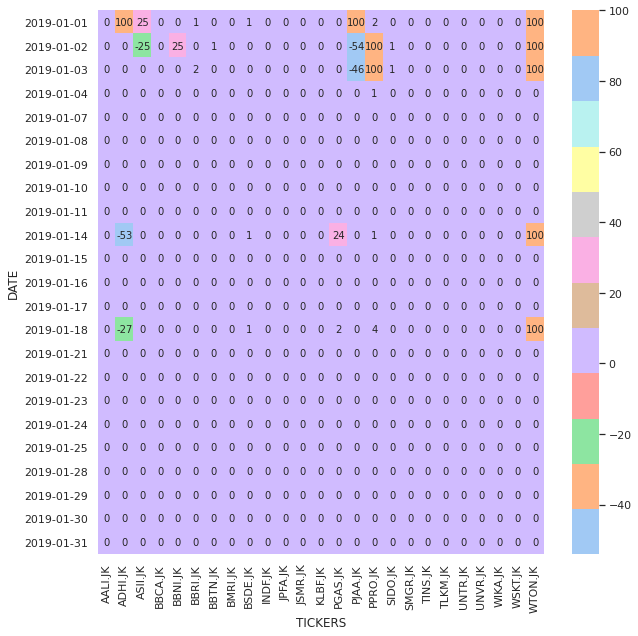

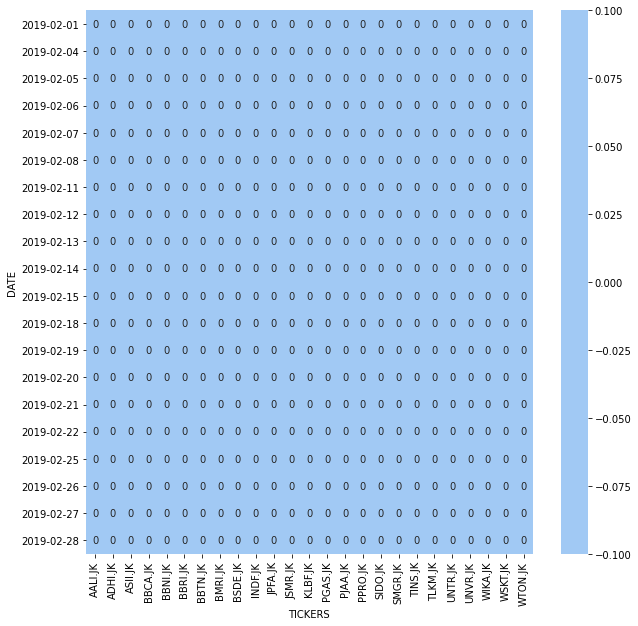

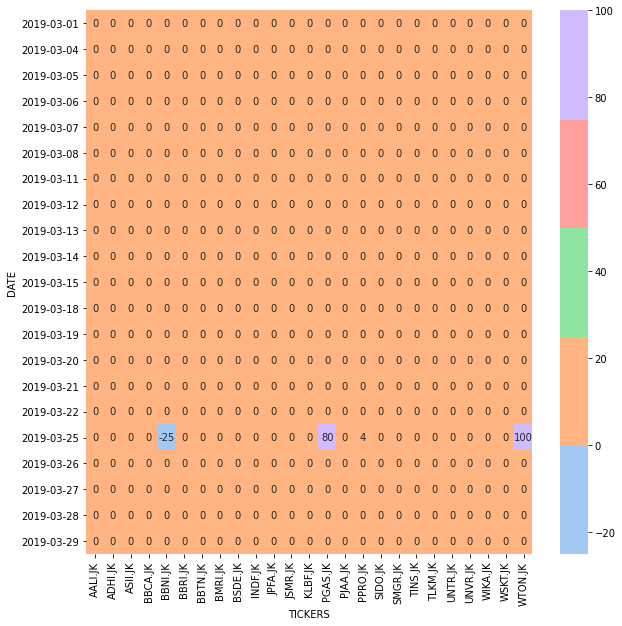

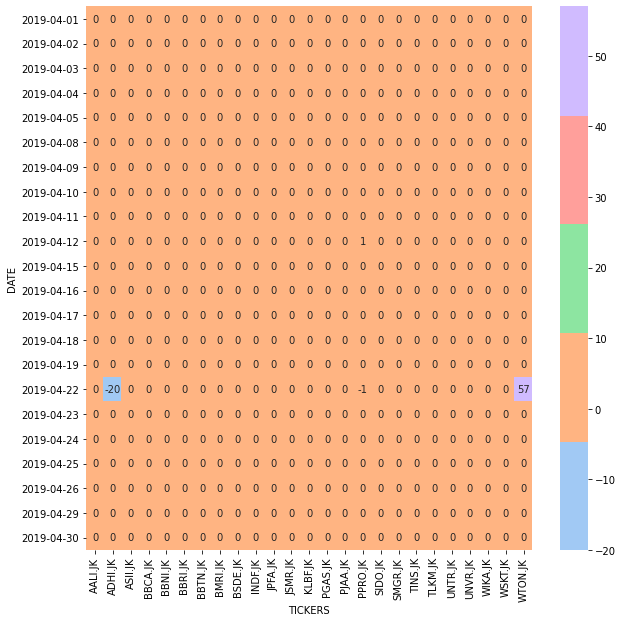

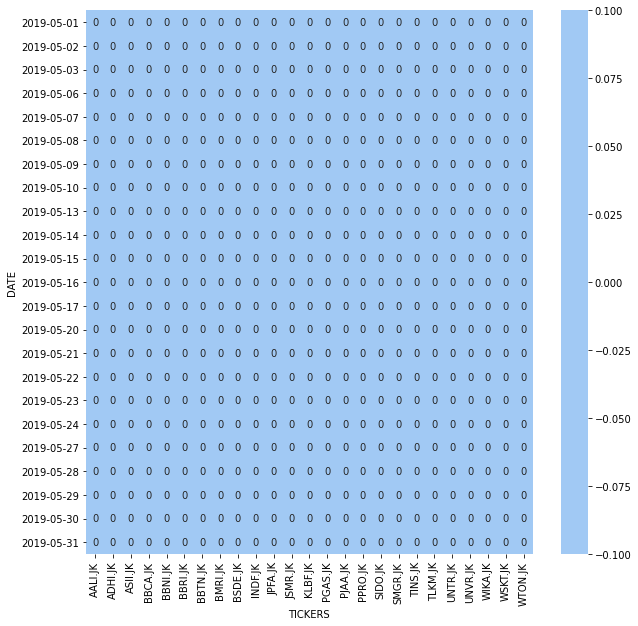

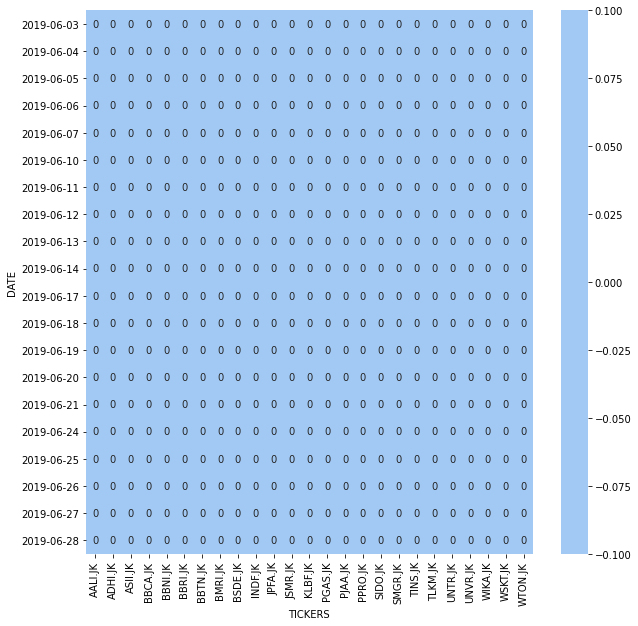

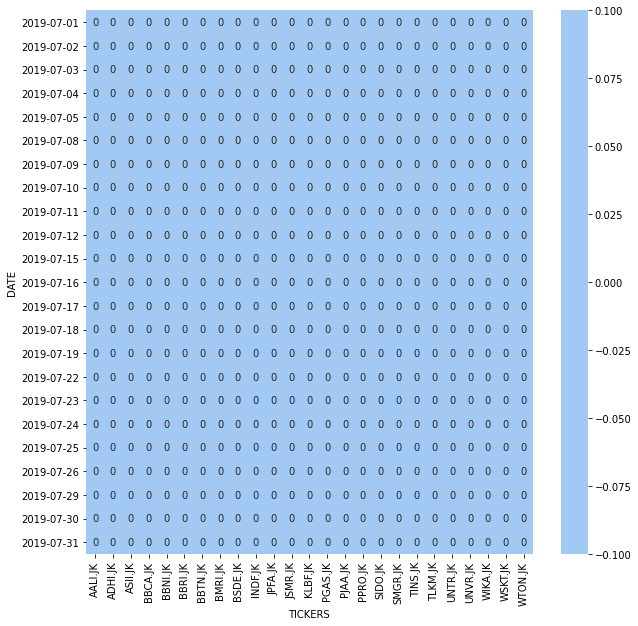

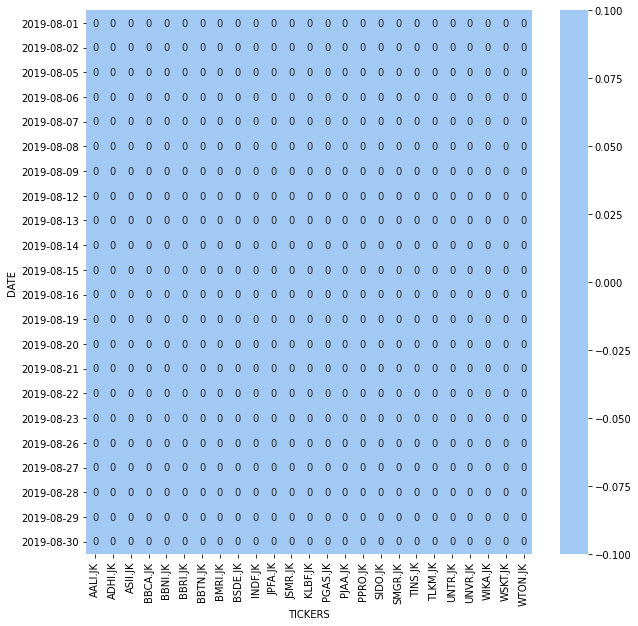

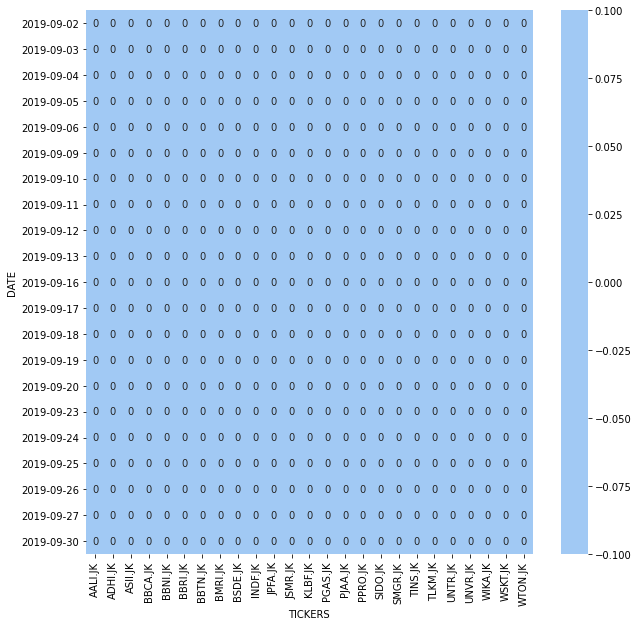

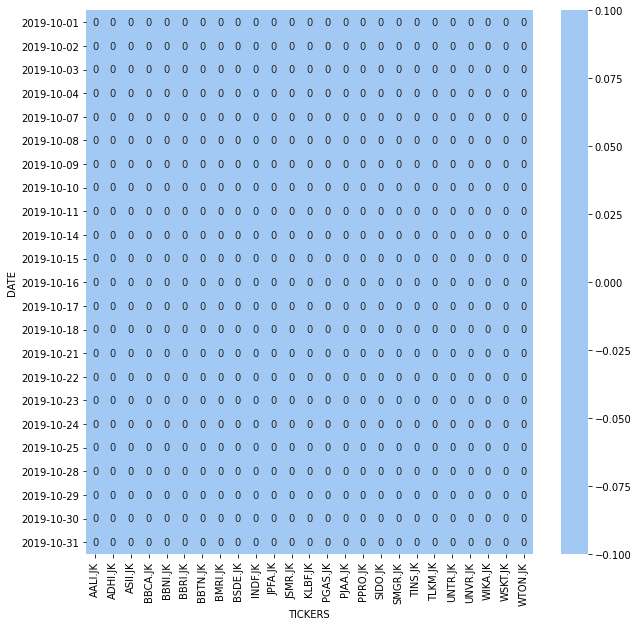

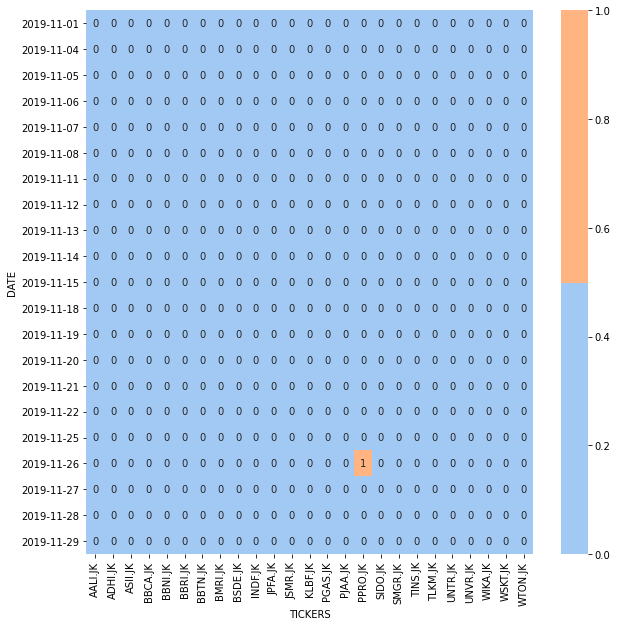

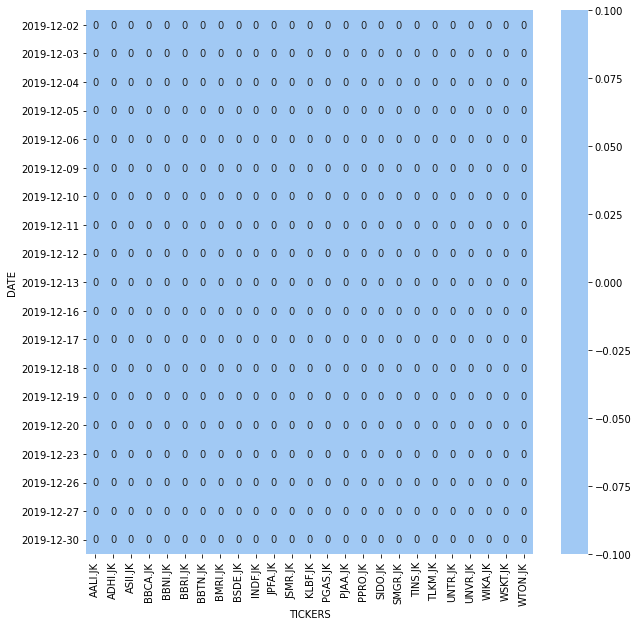

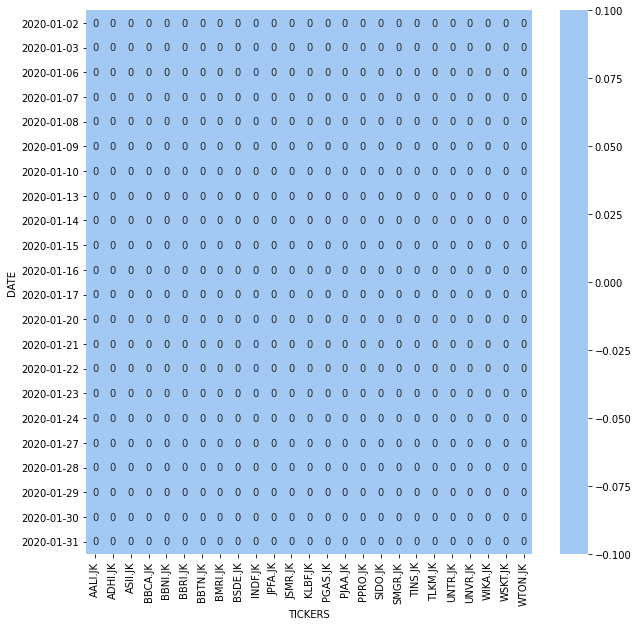

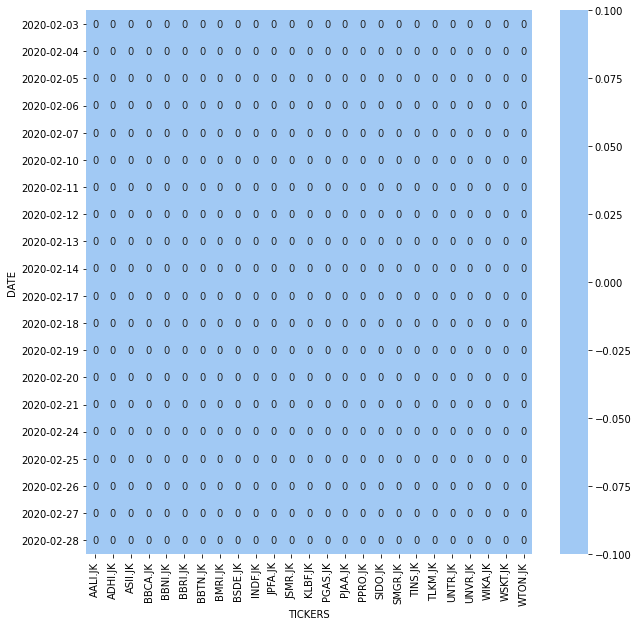

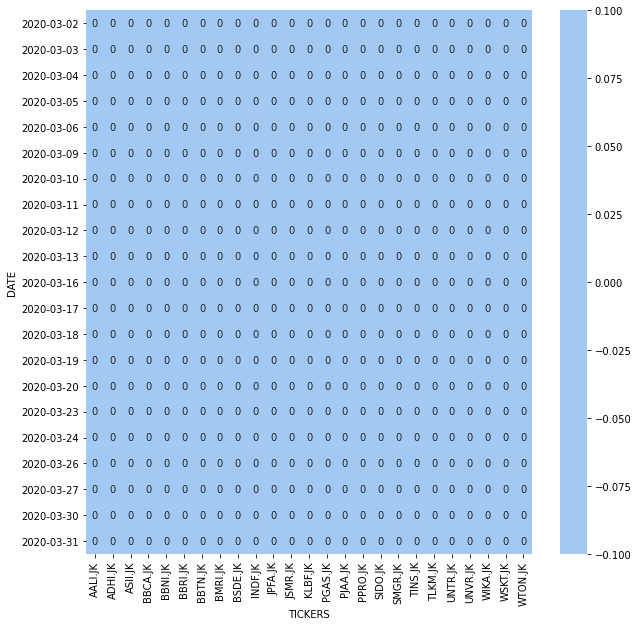

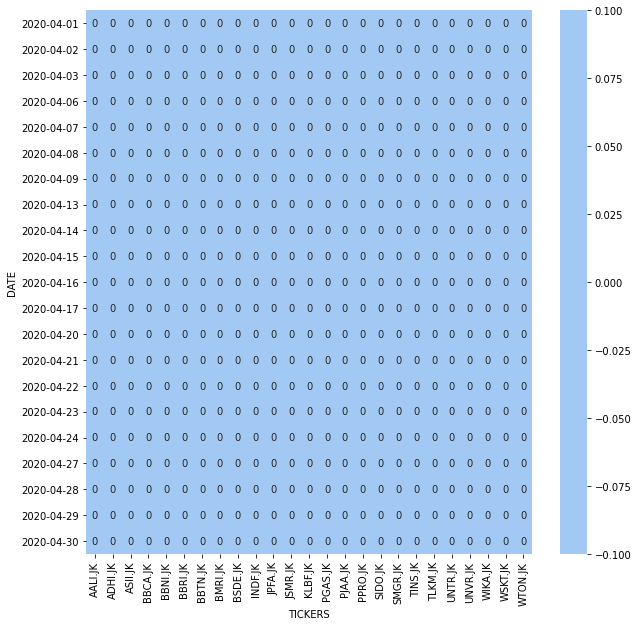

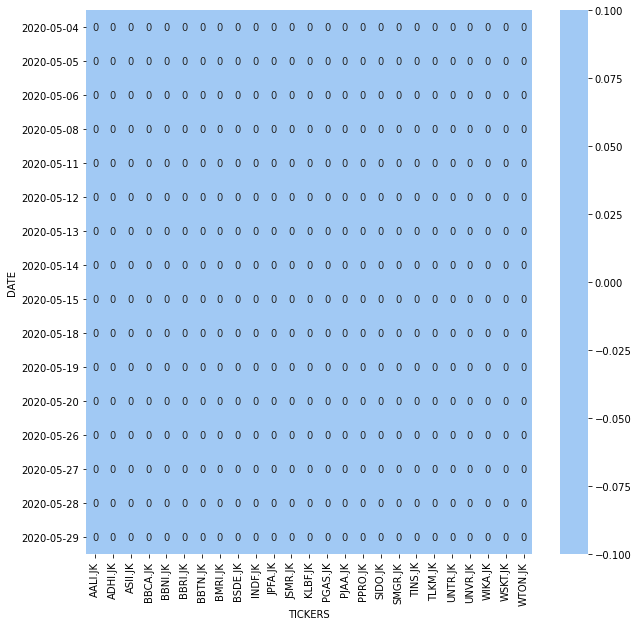

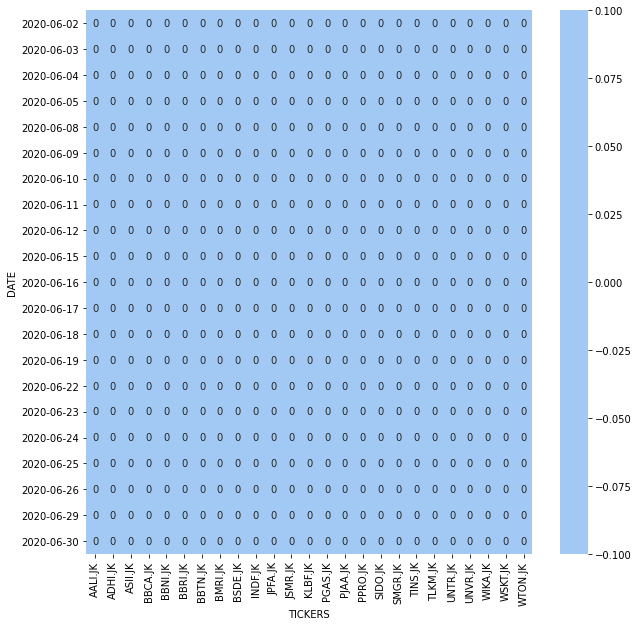

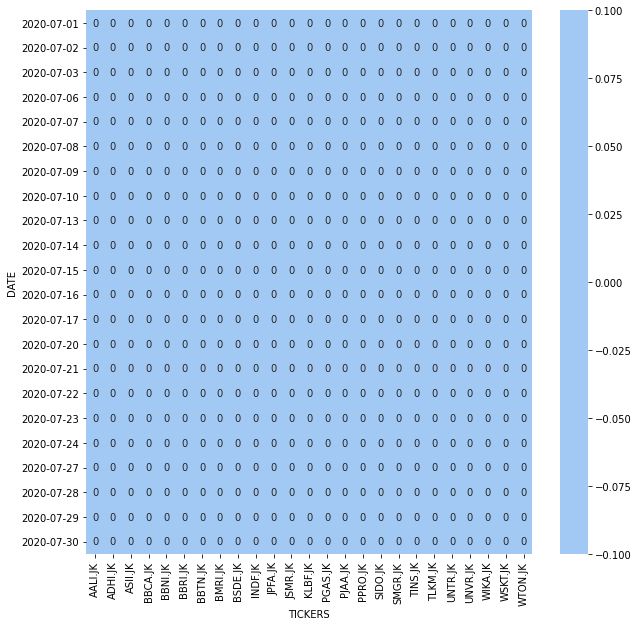

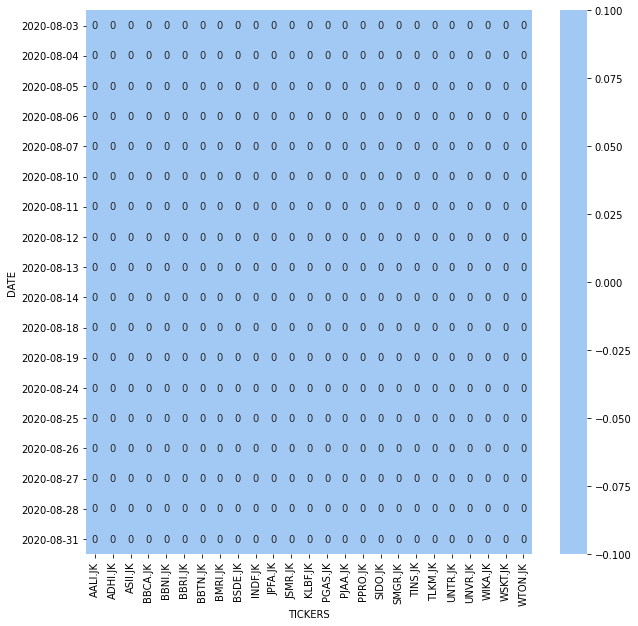

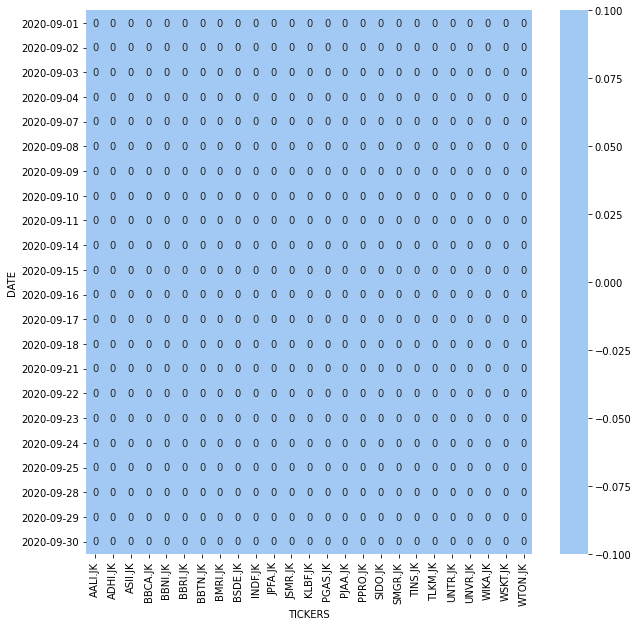

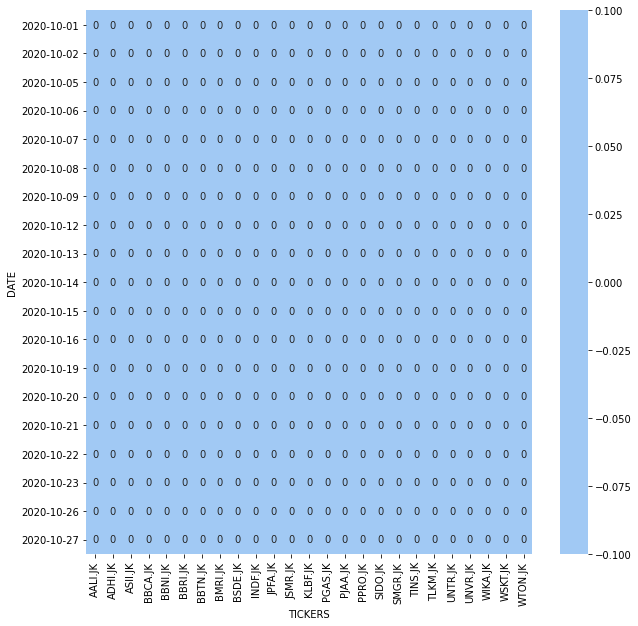

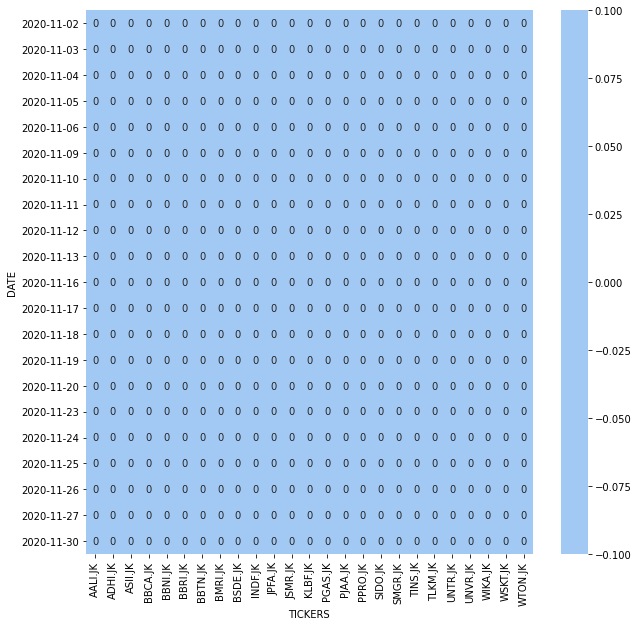

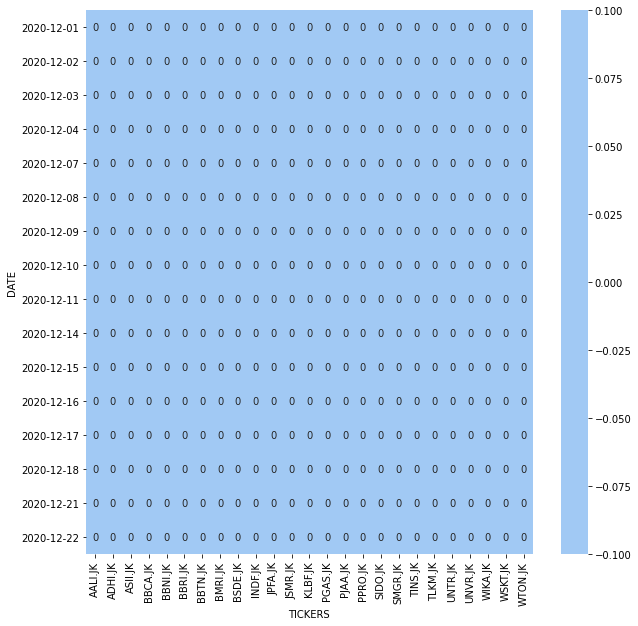

In [111]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
sns.set()
%matplotlib inline

def cmap_discretize(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)
    """

    if type(cmap) == str:
        cmap = plt.get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki,key in enumerate(('red','green','blue')):
        cdict[key] = [ (indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki]) for i in range(N+1) ]
    # Return colormap object.
    return matplotlib.colors.LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)

def colorbar_index(ncolors, cmap, data):

    """Put the colorbar labels in the correct positions
        using uique levels of data as tickLabels
    """

    cmap = cmap_discretize(cmap, ncolors)
    mappable = matplotlib.cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(np.unique(data))

df_actions_viz = df_actions.copy()
df_actions_viz['year'] = pd.to_datetime(df_actions_viz.index).year
df_actions_viz['month'] = pd.to_datetime(df_actions_viz.index).month
year_list = df_actions_viz['year'].unique()
month_list = df_actions_viz['month'].unique()
year_list.sort()
month_list.sort()
for year in year_list:
    for month in month_list:
        temp_df = df_actions_viz[(df_actions_viz['year']==year) & (df_actions_viz['month']==month)]
        temp_df = temp_df.drop(columns=['year','month'])

        unique_actions = len(np.unique(temp_df.values))
        f, ax = plt.subplots(figsize=(10, 10))
#         ax = sns.heatmap(temp_df,ax=ax,cmap=sns.color_palette("pastel", unique_actions))
#         cmap = sns.cubehelix_palette(n_colors=3,start=2.8, rot=.1, light=0.9, as_cmap=True)
#         cmap = sns.color_palette("icefire", as_cmap=True)
#         cmap.set_under('gray')
        ax = sns.heatmap(temp_df,cmap=sns.color_palette("pastel", unique_actions),annot=True,fmt='g')
#         colorbar_index(ncolors=len(np.unique(temp_df.values)), cmap=cmap,data=temp_df.values) 
        
        ax.set_ylabel('DATE')
        ax.set_xlabel('TICKERS')
        
        # Rotate tick labels
        locs, labels = plt.xticks()
        locs, labels = plt.yticks()
        plt.setp(labels, rotation=0)

        # revert matplotlib params
        sns.reset_orig()

        plt.show()

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [112]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = BackTestStats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return         -0.018388
Cumulative returns    -0.036012
Annual volatility      0.422291
Sharpe ratio           0.163918
Calmar ratio          -0.026332
Stability              0.586663
Max drawdown          -0.698323
Omega ratio            1.030321
Sortino ratio          0.247837
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.923154
Daily value at risk   -0.052929
Alpha                  0.000000
Beta                   1.000000
dtype: float64


<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to IHSG===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (484, 8)


Start date,2019-01-03
End date,2020-12-23
Total months,23
,Backtest
Annual return,-4.283%
Cumulative returns,-8.048%
Annual volatility,42.294%
Sharpe ratio,0.10
Calmar ratio,-0.06
Stability,0.67
Max drawdown,-69.832%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,69.83,2019-05-02,2020-04-14,NaT,NaN
1,7.23,2019-02-11,2019-02-19,2019-03-01,15
2,3.88,2019-01-17,2019-01-30,2019-02-06,15
3,3.17,2019-03-22,2019-03-28,2019-04-02,8
4,2.87,2019-04-25,2019-04-30,2019-05-02,6


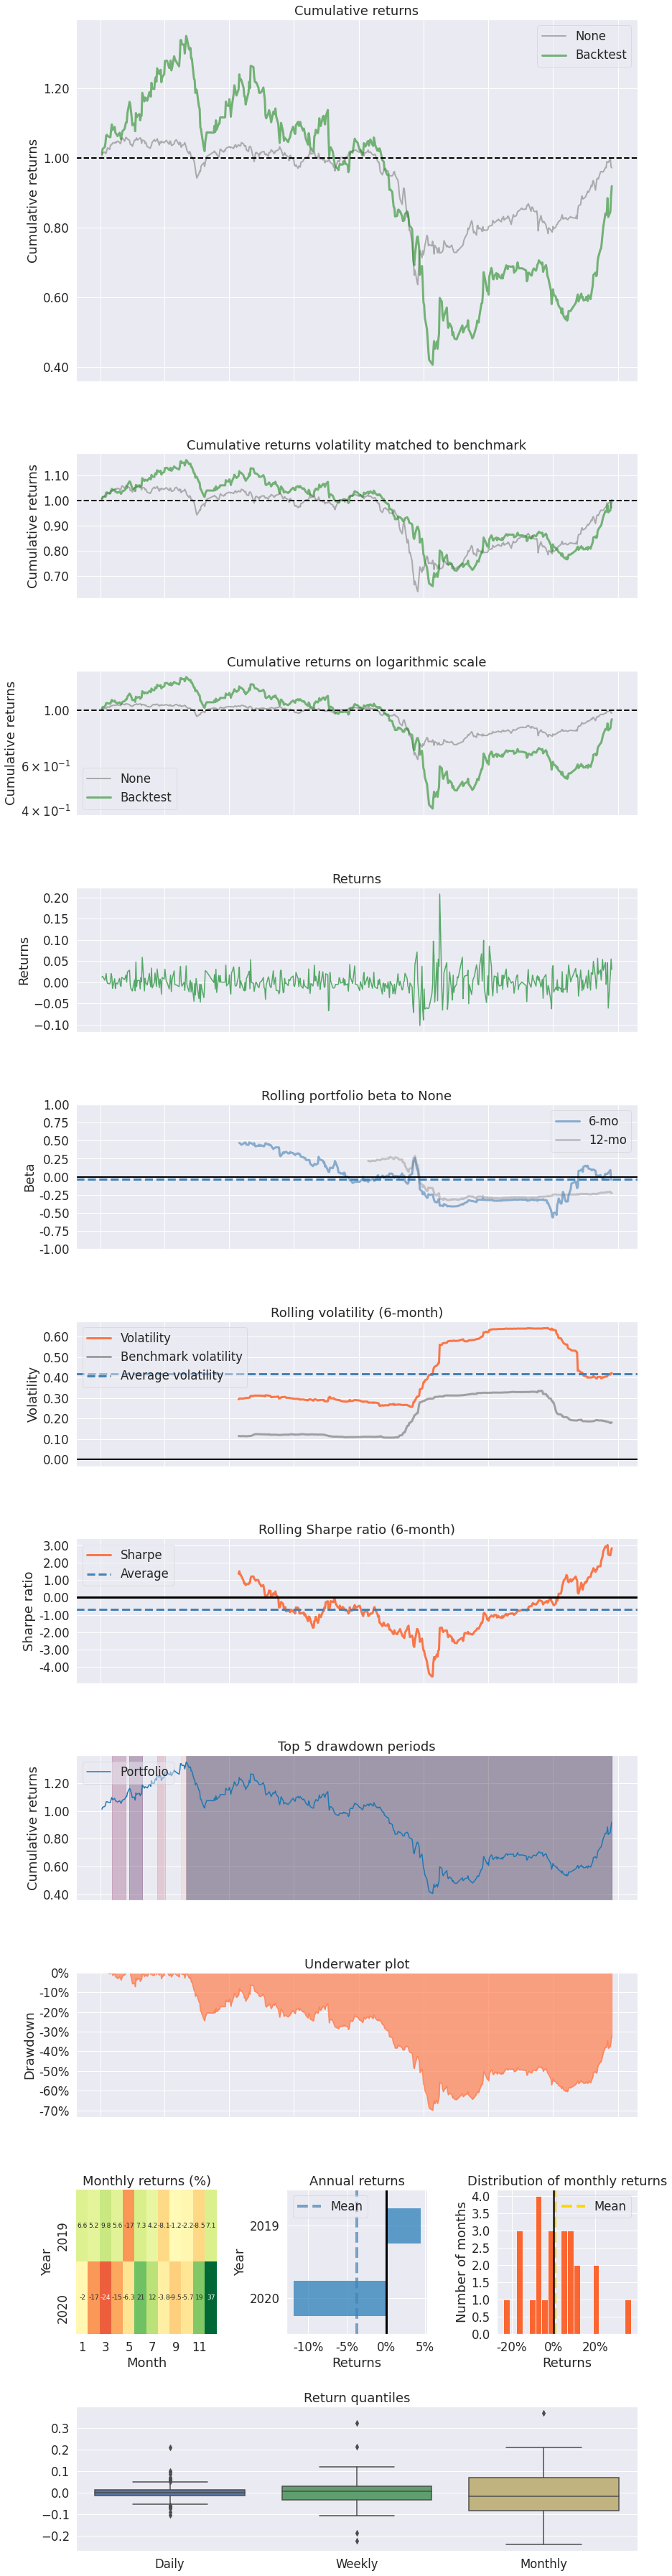

In [113]:
print("==============Compare to IHSG===========")
%matplotlib inline
BackTestPlot(df_account_value, 
             baseline_ticker = '^JKSE', 
             baseline_start = '2019-01-01',
             baseline_end = '2021-01-01')

<a id='6.3'></a>
## 7.3 Baseline Stats

In [115]:
print("==============Get Baseline Stats===========")
baseline_perf_stats=BaselineStats('^JKSE',
                                  baseline_start = '2019-01-01',
                                  baseline_end = '2021-01-01')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (484, 8)
Annual return         -0.014626
Cumulative returns    -0.027902
Annual volatility      0.205862
Sharpe ratio           0.030856
Calmar ratio          -0.036689
Stability              0.514994
Max drawdown          -0.398640
Omega ratio            1.006025
Sortino ratio          0.043244
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.007454
Daily value at risk   -0.025911
Alpha                  0.000000
Beta                   1.000000
dtype: float64
